# Bookmark Clustering

## Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import seaborn as sns
from time import time
import matplotlib.pyplot as plt 
%matplotlib inline

Test out K-means
LDA
Go back to Galvanize assignments and review topic modeling - NMF etc.

In [2]:
df = pd.read_pickle('Data/df_website_content.pkl')

In [3]:
df = df.drop_duplicates()

In [4]:
df = df[df['text'] != 'empty']

In [5]:
df = df.sample(frac=1)

In [6]:
df.reset_index(drop=True, inplace=True)

## K-Means

The goal here is to try and determine how many topics to use for the other clustering algorithms

Sklearn KMeans centers the data but doing normalization explicitly here 

In [23]:
tf_idf_vectorizer = TfidfVectorizer(stop_words='english', min_df=2, max_df=.95)
tf_idf = tf_idf_vectorizer.fit_transform(df['text'])

In [8]:
tf_idf = normalize(tf_idf)

In [9]:
def build_models(data, cluster_lst, n_iter, jobs=4):
    model_dict = {}
    for k in cluster_lst:
        model_dict[k] = {}
        model = KMeans(n_clusters=k, n_init=n_iter, n_jobs=jobs, random_state=123)
        model_dict[k]['model'] = model
        model_dict[k]['distances'] = model.fit_transform(tf_idf)
    return model_dict

In [10]:
k_lst = np.arange(5, 120, 20)

In [11]:
start = time()
models_dict = build_models(tf_idf, k_lst, 15, 4)
end = time()
print end - start

210.365999937


In [12]:
h_lst = [abs(models_dict[k]['model'].score(tf_idf)) for k in k_lst]

In [13]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

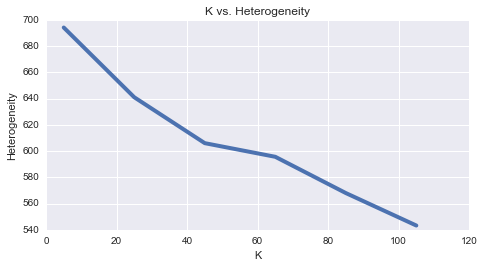

In [14]:
plot_k_vs_heterogeneity(k_lst, h_lst)

In [15]:
def print_bin_counts(models, cluster_lst):
    for k in cluster_lst:
        print "bin count of cluster {0}:".format(k)
        np.bincount(models[k]['model'].labels_)

Build a function to plot bincounts for a particular cluster count k

In [16]:
def plt_cluster_counts(k_val, models, ticks=True, logscale=False):
    labels = models[k_val]['model'].labels_
    g = sns.barplot(x=np.arange(k_val), y=np.bincount(labels))
    if not ticks:
        g.set(xticklabels=[])
    if logscale:
        g.figure.get_axes()[0].set_yscale('log')
    else: plt.show()

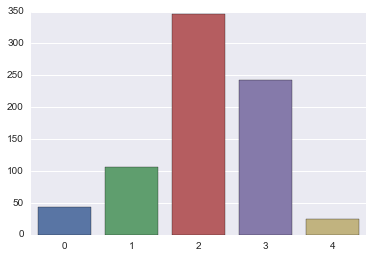

In [17]:
plt_cluster_counts(5, models_dict)

Most of the bookmarks are data science, pure math, or finance.  Three major cluster groups make sense in this context.

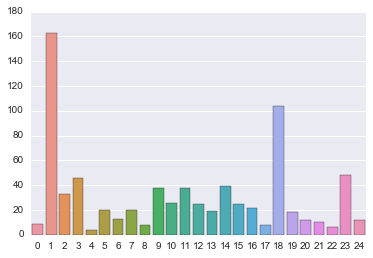

In [18]:
plt_cluster_counts(25, models_dict)

At a cluster number of K=45

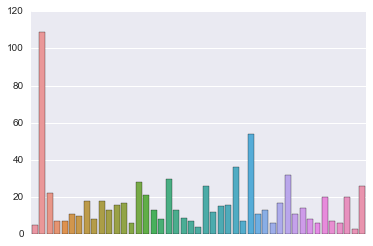

In [19]:
plt_cluster_counts(45, models_dict, ticks=False)

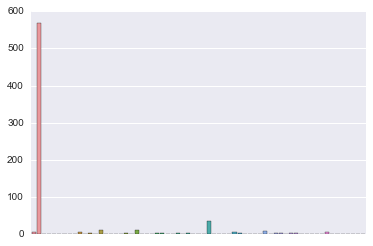

In [21]:
plt_cluster_counts(65, models_dict, ticks=False)

In [25]:
indx_to_word = {v:k for k,v in tf_idf_vectorizer.vocabulary_.iteritems()}

In [103]:
mat_0 = tf_idf[models_dict[5]['model'].labels_ == 0].todense()

(1L, 40580L)

In [35]:
idx = mat_0.argsort()[::-1]

In [108]:
test_mat = np.array([[2,3,1,0],[4,6,7,2],[9,8,5,6],[0,3,20,5]])
test_mat

array([[ 2,  3,  1,  0],
       [ 4,  6,  7,  2],
       [ 9,  8,  5,  6],
       [ 0,  3, 20,  5]])

In [105]:
def largest_indices(mat, n):
    """Returns the n largest indices from a numpy array."""
    #indices = (-full).argpartition(num_largest, axis=None)[:num_largest]
    # OR, if you want to avoid the temporary array created by `-full`:
    indices = mat.argpartition(mat.size - n, axis=None)[-n:]

    return np.unravel_index(indices, mat.shape)

In [120]:
x, y = largest_indices(mat_0, 2)

In [122]:
x.shape

(1L, 1255364L)

In [101]:
num_largest = 4
full = test_mat
indices = (-full).argpartition(num_largest, axis=None)[:num_largest]
# OR, if you want to avoid the temporary array created by `-full`:
# indices = full.argpartition(full.size - num_largest, axis=None)[-num_largest:]

x, y = np.unravel_index(indices, full.shape)

In [100]:
x

array([3, 2, 2], dtype=int64)

In [ ]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in xrange(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in xrange(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(map_index_to_word['category'][idx[i]], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in xrange(8):
                text = ' '.join(wiki[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki[nearest_neighbors[i]]['name'],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

## LDA

Not all topics have a clear theme
Things to try:
try setting max_features in cv (this seemed to help)
use graphlab
modify alpha and beta in LDA
reduce the number of topics
*there was something about using k-means (elbow plot to initalize other algos)

In [ ]:
cv = CountVectorizer(stop_words='english', min_df=2, max_df=.95)

In [ ]:
cv2 = CountVectorizer(stop_words='english', min_df=2, max_df=.95, max_features=10000)

In [ ]:
cv3 = CountVectorizer(stop_words='english', min_df=2, max_df=.95, max_features=5000)

In [ ]:
tf = cv.fit_transform(df['text'])

In [ ]:
tf2 = cv2.fit_transform(df['text'])

In [ ]:
tf3 = cv3.fit_transform(df['text'])

In [ ]:
len(cv.get_feature_names())

In [ ]:
len(cv2.get_feature_names())

In [ ]:
lda_1 = LatentDirichletAllocation(n_topics=30, max_iter=100, n_jobs=4, doc_topic_prior=5.0, topic_word_prior=None, random_state=0)

In [ ]:
lda_2 = LatentDirichletAllocation(n_topics=30, max_iter=100, n_jobs=4, doc_topic_prior=5.0, topic_word_prior=None, random_state=0)

In [ ]:
lda_3 = LatentDirichletAllocation(n_topics=30, max_iter=100, n_jobs=4, doc_topic_prior=5.0, topic_word_prior=None, random_state=0)

In [ ]:
t0 = time()
lda_1.fit(tf)
print "done in {0}".format(time()-t0)

In [ ]:
t0 = time()
lda_2.fit(tf2)
print "done in {0}".format(time()-t0)

In [ ]:
t0 = time()
lda_3.fit(tf3)
print "done in {0}".format(time()-t0)

In [ ]:
lda_2.components_[0]

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print "Topic #%d:" % topic_idx
        print " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

In [ ]:
print_top_words(lda_1, cv.get_feature_names(), 20)

In [ ]:
print_top_words(lda_2, cv2.get_feature_names(), 20)

In [ ]:
print_top_words(lda_3, cv3.get_feature_names(), 20)

Try using graplab

In [ ]:
lda_2.transform(tf2)[0]

## Code Archive